# WiCoNet

In [10]:
import os
import cv2
import time
import datetime
import numpy as np
import torch.autograd
from skimage import io
from scipy import stats
import torch.nn.functional as F
from torch.utils.data import DataLoader
from utils.loss import CrossEntropyLoss2d
from utils.utils import accuracy, intersectionAndUnion, AverageMeter, CaclTP
import cv2
from matplotlib import pyplot as plt
import os

from datasets import my_dataset as MY
from models.WiCoNet import WiCoNet as Net
NET_NAME = 'WiCoNet_3hw4L'
DATA_NAME = 'MY'

In [2]:
working_path = os.path.abspath('.')
args = {
    'gpu': True,
    's_class': 0,
    'val_batch_size': 1,
    'size_local': 128,
    'size_context': 128 * 3,
    'data_dir': '/home/jovyan/fominaav/tile-based-problem/my-dataset/',
    'load_path': '/home/jovyan/fominaav/tile-based-problem/WiCoNet/checkpoints/MY/WiCoNet_3hw4L_6e_OA60.06.pth',
    'num_workers': 4
}

In [4]:
net = Net(3, num_classes=MY.num_classes + 1, 
          size_context=args['size_context'],
          size_local=args['size_local']).cuda()
net.load_state_dict(torch.load(args['load_path']))

<All keys matched successfully>

In [19]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [20]:
count_parameters(net)

38457866

In [5]:
val_set = MY.Loader(args['data_dir'], 'val', sliding_crop=True, 
                    size_context=args['size_context'], 
                    size_local=args['size_local'])
val_loader = DataLoader(val_set, batch_size=args['val_batch_size'], 
                        num_workers=args['num_workers'], shuffle=False)

Reading data from /home/jovyan/fominaav/tile-based-problem/my-dataset/:
10/10 images loaded.
(512, 512, 3)
10 val images loaded.
Sliding crop finished. 160 images created.


In [6]:
MEAN = np.array([122.22, 113.40, 94.81])
STD  = np.array([83.51, 76.91, 82.42])

def denormalize_image(im):
    return im * STD + MEAN

In [139]:
i = 80
for vi, data in enumerate(val_loader):
    if vi >= i:
        imgs_s, labels_s, imgs, labels = data
        break

In [140]:
if args['gpu']:
    imgs = imgs.cuda().float()
    labels = labels.cuda().long()
    imgs_s = imgs_s.cuda().float()

with torch.no_grad():
    outputs, _ = net(imgs_s, imgs)

outputs = outputs.cpu().detach()
labels = labels.cpu().detach().numpy()
preds = torch.argmax(outputs, dim=1)
preds = preds.numpy()

In [141]:
from skimage import color
img = denormalize_image(imgs[0].cpu().detach().numpy().transpose(1, 2, 0)).astype('uint8')
pred_mask_to_show = color.label2rgb(preds[0],
                                    img, 
                                    bg_label=0, kind='overlay', 
                                    saturation=1)

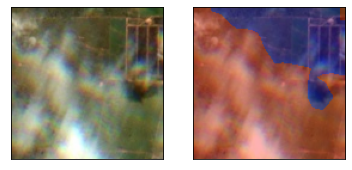

In [142]:
f, ax = plt.subplots(1,2)
ax[0].imshow(img)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].imshow(pred_mask_to_show)
ax[1].set_xticks([])
ax[1].set_yticks([])
plt.show()

# ViT

In [ ]:
import mmcv
sys.path.append('../../mmsegmentation/')
import mmseg
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
from mmseg.core.evaluation import get_palette
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset
from mmseg.datasets import build_dataloader, build_dataset

In [ ]:
config_file = '../../mmsegmentation/configs/my_configs/vit_config.py'
checkpoint_file = 'work_dirs/vit/iter_4000.pth'

In [ ]:
model = init_segmentor(config_file, checkpoint=checkpoint_file, device='cuda:0')

In [ ]:
def test_on_img(path):
    img = cv2.imread(path)
    result = inference_segmentor(model, img)
    palette = [[128, 128, 128], [129, 127, 38], [120, 69, 125], [53, 125, 34]]
    show_result_pyplot(model, img, result, palette,  fig_size=(10, 10))